Nouveau Custom score ok ? Pour pouvoir comparer les résultats meme si le nombre d'entrées est tres différent.

In [1]:
import os
import time
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

import mlflow
import tensorflow as tf
from tensorflow.python.client import device_lib
from mlflow.models import infer_signature
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix, make_scorer
from sklearn.model_selection import KFold, StratifiedKFold
import shap

In [2]:
df = pd.read_csv("dataframe_final.csv")

On divise notre dataframe en train et test en fonction de la présence de l'information dans 'TARGET'.

In [3]:
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]

print(f'train_df shape : {train_df.shape}')
print(f'test_df shape : {test_df.shape}')

train_df shape : (307507, 797)
test_df shape : (48744, 797)


In [4]:
train_df_30k = train_df.sample(n=30000, stratify=train_df['TARGET'], random_state=0)

TypeError: NDFrame.sample() got an unexpected keyword argument 'stratify'

In [5]:
# To start the mlflow server in local : mlflow server --host 127.0.0.1 --port 8080

mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("OCR_Project7")

<Experiment: artifact_location='mlflow-artifacts:/660074711239750018', creation_time=1706799735679, experiment_id='660074711239750018', last_update_time=1706799735679, lifecycle_stage='active', name='OCR_Project7', tags={}>

In [43]:
def custom_score_func(y, y_pred):
    cf_matrix = confusion_matrix(y, y_pred)
    FN = cf_matrix[1,0]
    FP = cf_matrix[0,1]

    return (10*FN+FP)/y.shape[0]

In [45]:
custom_scorer = make_scorer(custom_score_func, greater_is_better=False)

In [8]:
def calcul_metrics(model, X, y):
    """Fonction de calcul des metriques précision, AUC et score_metier en fonction du modèle en entrée. Retourne un dictionnaire."""
    metrics = {}
    
    accuracy = model.score(X, y)
    print(f'Précision : {accuracy:.2f}')
    metrics['accuracy'] = accuracy
    
    roc_auc = roc_auc_score(y, model.predict_proba(X)[:,1])
    print(f'AUC : {roc_auc:.2f}')
    metrics['roc_auc'] = roc_auc

    #cf_matrix = confusion_matrix(y, model.predict(X))
    #FN = cf_matrix[1,0]
    #FP = cf_matrix[0,1]
    score_metier = custom_score_func(y, model.predict(X))
    print(f'Score métier : {score_metier}')
    metrics['score_metier'] = score_metier

    return metrics
    

In [9]:
def logToMLflow(model, X, eval_data, metrics, name="", params="", training_tag=""):
    # Start an MLflow run
    with mlflow.start_run(run_name=name):
        # Log the hyperparameters
        if params:
            mlflow.log_params(params)

        # Log the loss metric
        mlflow.log_metric("accuracy", metrics['accuracy'])
        mlflow.log_metric("roc_auc", metrics['roc_auc'])
        mlflow.log_metric("score_metier", metrics['score_metier'])
    
        # Set a tag that we can use to remind ourselves what this run was for
        if training_tag:
            mlflow.set_tag("Training Info", training_tag)
    
        # Infer the model signature
        signature = infer_signature(X, model.predict(X))
    
        # Log the model
        model_info = mlflow.sklearn.log_model(model, 'model', signature=signature)

        result = mlflow.evaluate(
            model_info.model_uri,
            eval_data,
            targets="TARGET",
            model_type="classifier",
            evaluators=["default"],
        )

In [34]:
def displayConfMatrix(model, valid_x, valid_y):
    plt.figure(figsize=(12,6))
    cf_matrix = confusion_matrix(valid_y, model.predict(valid_x))
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
      
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')
    plt.show()

In [28]:
#Fonction d'affichage des résultats d'un GridSearch.

def resultizeGrid(grid):
    res = grid.cv_results_
    res = pd.DataFrame(res)
    cols = [i for i in res.columns if "split" not in i]
    res = res[cols]
    res = res.sort_values('rank_test_CustomScorer')
    
    return res

# LOGISTIC REGRESSION

In [52]:
feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

train_x, valid_x, train_y, valid_y = train_test_split(train_df[feats], train_df['TARGET'], test_size=0.15, random_state=0)

In [60]:
col = train_x.columns

train_x.replace([np.inf, -np.inf], np.nan, inplace=True)
valid_x.replace([np.inf, -np.inf], np.nan, inplace=True)

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
train_x = imp.fit_transform(train_x)
valid_x = imp.fit_transform(valid_x)

train_x = pd.DataFrame(train_x, columns=col)
valid_x = pd.DataFrame(valid_x, columns=col)

In [13]:
train_x_30k = train_x[:30000]
train_y_30k = train_y[:30000]

In [61]:
train_x_10k = train_x[:10000]
train_y_10k = train_y[:10000]

## Without SMOTE

Gestion des valeurs manquantes.

In [21]:
%%time

lr = LogisticRegression(random_state=0)
lr.fit(train_x, train_y)

metrics = calcul_metrics(lr, valid_x, valid_y)
print(classification_report(valid_y, lr.predict(valid_x)))

val_data = pd.concat([valid_x.reset_index(drop=True), valid_y.reset_index(drop=True)], axis=1)
logToMLflow(lr, train_x, val_data, metrics, name="LogReg_noSmote_noParam", training_tag="Basic LR model no SMOTE no param")

displayConfMatrix(lr, valid_x, valid_y)

Précision : 0.92
AUC : 0.53
Score métier : 36756
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     42452
         1.0       0.08      0.00      0.00      3675

    accuracy                           0.92     46127
   macro avg       0.50      0.50      0.48     46127
weighted avg       0.85      0.92      0.88     46127



2024/02/01 16:11:45 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2024/02/01 16:11:45 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1.0, negative label is 0.0.
2024/02/01 16:11:48 INFO mlflow.models.evaluation.default_evaluator: Shap explainer Linear is used.
2024/02/01 16:11:48 WARNING mlflow.models.evaluation.default_evaluator: Logging explainer failed. Reason: AttributeError("'LogisticRegression' object has no attribute 'save'"). Set logging level to DEBUG to see the full traceback.


CPU times: total: 2min 8s
Wall time: 25 s


## Features Importances

### Native coef function

In [33]:
plt.figure(figsize=(12,6))
color_list =  sns.color_palette("dark", len(train_df.columns)) 
top_x = 10
logistic_reg_coeff = lr.coef_[0]
idx = np.argsort(np.abs(logistic_reg_coeff))[::-1] 
lreg_ax = plt.barh(train_df.columns[idx[:top_x]][::-1], logistic_reg_coeff[idx[:top_x]][::-1])
for i,bar in enumerate(lreg_ax):
  bar.set_color(color_list[idx[:top_x][::-1][i]])
  plt.box(False) 
lr_title = plt.suptitle("Logistic Regression. Top " + str(top_x) + " Coefficients.", fontsize=20, fontweight="normal")

NameError: name 'lr' is not defined

### SHAP

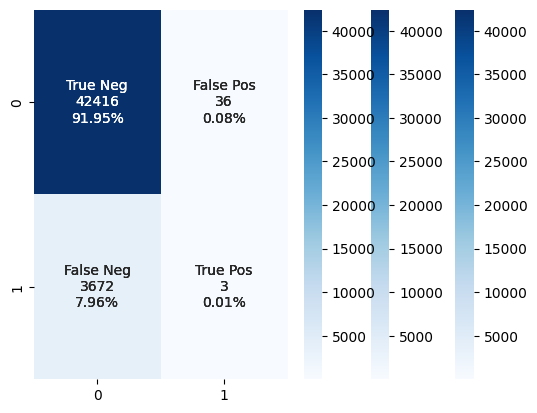

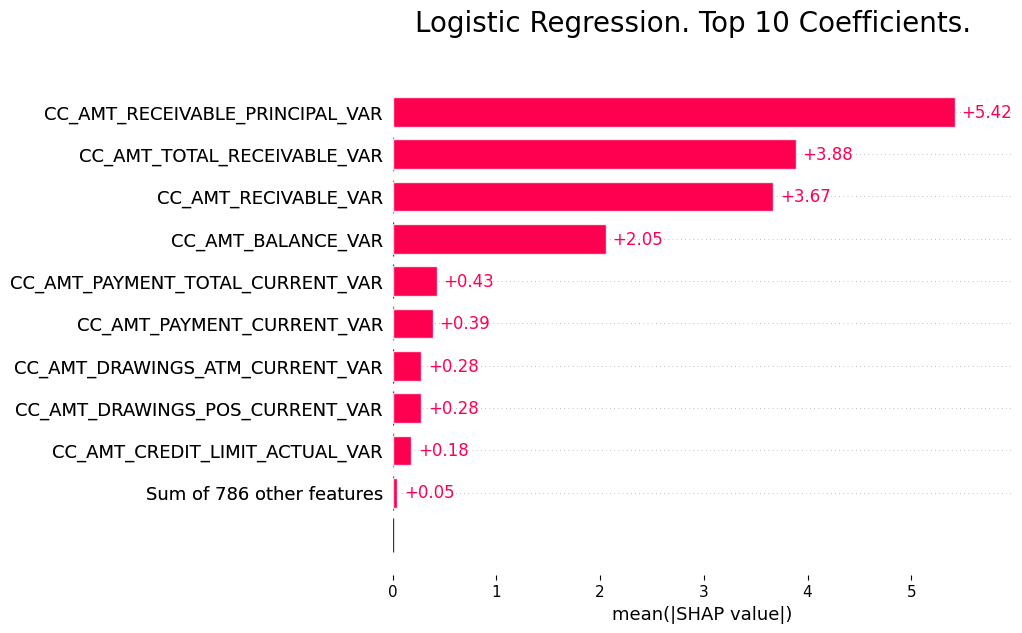

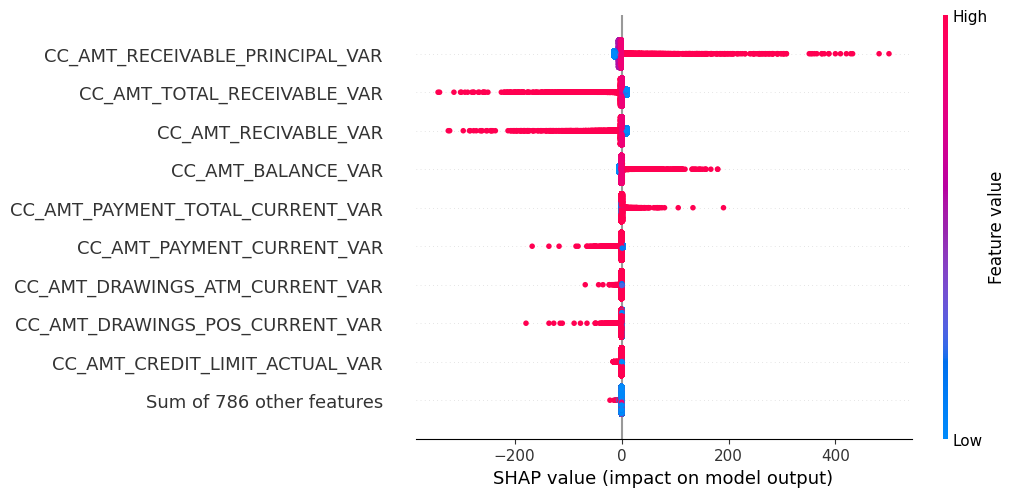

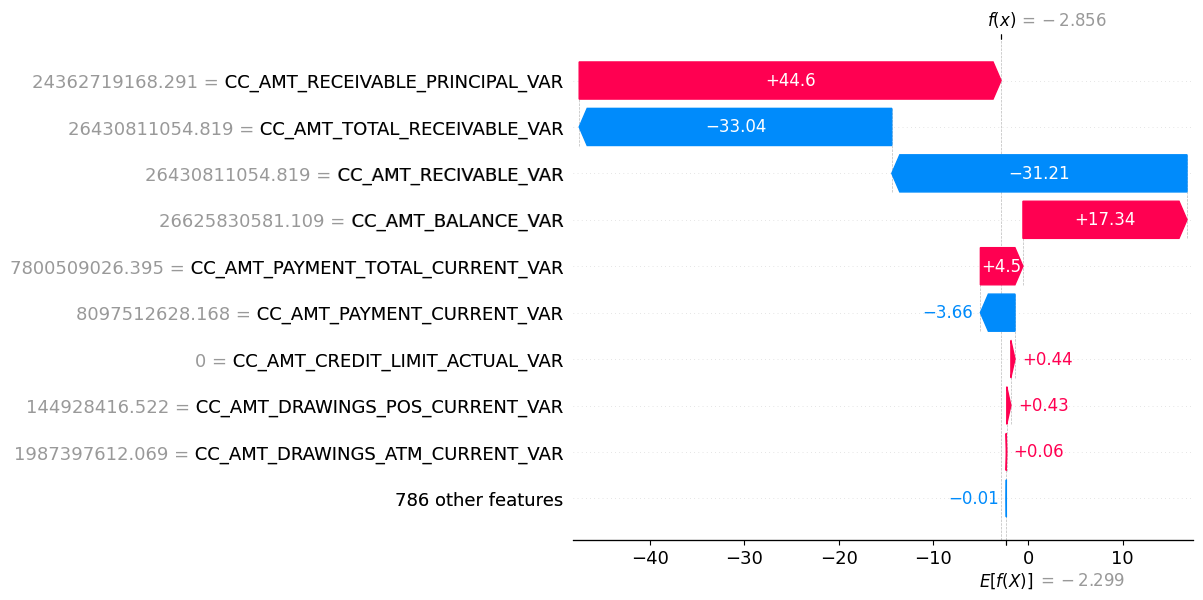

In [30]:
lin_explainer = shap.LinearExplainer(lr, train_x)

shap_values = lin_explainer(valid_x)

shap.plots.bar(shap_values)
shap.plots.beeswarm(shap_values)
shap.plots.waterfall(shap_values[50])

## With SMOTE

### No Param

In [14]:
%%time

steps = [('over', SMOTE(random_state=0)), ('model', LogisticRegression(random_state=0))]
pipeline = Pipeline(steps=steps)
pipeline.fit(train_x, train_y)


metrics = calcul_metrics(pipeline, valid_x, valid_y)
print(classification_report(valid_y, pipeline.predict(valid_x)))

val_data = pd.concat([valid_x.reset_index(drop=True), valid_y.reset_index(drop=True)], axis=1)
logToMLflow(pipeline, train_x, val_data, metrics, name="LogReg_Smote_noParam", training_tag="Basic LR model with SMOTE no param")

displayConfMatrix(pipeline, valid_x, valid_y)

Précision : 0.80
AUC : 0.54
Score métier : 35870
              precision    recall  f1-score   support

         0.0       0.92      0.85      0.89     42452
         1.0       0.10      0.19      0.13      3675

    accuracy                           0.80     46127
   macro avg       0.51      0.52      0.51     46127
weighted avg       0.86      0.80      0.83     46127



2024/02/05 14:11:47 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2024/02/05 14:11:47 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1.0, negative label is 0.0.
2024/02/05 14:11:51 INFO mlflow.models.evaluation.default_evaluator: Shap explainer Permutation is used.
2024/02/05 14:11:51 WARNING mlflow.models.evaluation.default_evaluator: Shap evaluation failed. Reason: ValueError('max_evals=500 is too low for the Permutation explainer, it must be at least 2 * num_features + 1 = 1387!'). Set logging level to DEBUG to see the full traceback.


CPU times: total: 4min 43s
Wall time: 57.6 s


<Figure size 1050x700 with 0 Axes>

### With GridSearchCV

In [47]:
%%time

params = {
    "model__C":np.logspace(-3, 3, 7)
}
scoring = {"AUC": "roc_auc", "CustomScorer": custom_scorer}

steps = [('over', SMOTE(random_state=0)), ('model', LogisticRegression(random_state=0))]
pipeline = Pipeline(steps=steps)
GS = GridSearchCV(pipeline, params, scoring=scoring, refit="CustomScorer", n_jobs = -1)

GS.fit(train_x_30k, train_y_30k)

print("Best parameters :",GS.best_params_)
print("Score :",GS.best_score_)
resultizeGrid(GS)

Best parameters : {'model__C': 0.01}
Score : -0.7922333333333335
CPU times: total: 5.75 s
Wall time: 1min 33s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,params,mean_test_AUC,std_test_AUC,rank_test_AUC,mean_test_CustomScorer,std_test_CustomScorer,rank_test_CustomScorer
1,33.155690,1.566126,0.205389,0.035673,0.01,{'model__C': 0.01},0.538922,0.010115,3,-0.792233,0.013749,1
0,30.732889,2.854110,0.265643,0.076835,0.001,{'model__C': 0.001},0.539554,0.009877,1,-0.792467,0.013386,2
2,30.367090,4.227141,0.201989,0.042486,0.1,{'model__C': 0.1},0.539317,0.010610,2,-0.793033,0.013296,3
3,28.616462,0.672648,0.192174,0.009908,1.0,{'model__C': 1.0},0.538471,0.010218,6,-0.793033,0.013218,3
5,26.032039,0.692128,0.161145,0.072761,100.0,{'model__C': 100.0},0.538485,0.010318,4,-0.793033,0.013390,3
6,24.287491,0.360761,0.055452,0.032003,1000.0,{'model__C': 1000.0},0.538485,0.010318,4,-0.793033,0.013390,3
4,29.546260,0.878920,0.211623,0.033994,10.0,{'model__C': 10.0},0.538245,0.009861,7,-0.793267,0.013149,7


Précision : 0.40
AUC : 0.54
Score métier : 0.8418063173412534
              precision    recall  f1-score   support

         0.0       0.93      0.38      0.54     42452
         1.0       0.08      0.66      0.15      3675

    accuracy                           0.40     46127
   macro avg       0.51      0.52      0.34     46127
weighted avg       0.86      0.40      0.51     46127



2024/02/05 14:57:34 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2024/02/05 14:57:34 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1.0, negative label is 0.0.
2024/02/05 14:57:38 INFO mlflow.models.evaluation.default_evaluator: Shap explainer Permutation is used.
2024/02/05 14:57:38 WARNING mlflow.models.evaluation.default_evaluator: Shap evaluation failed. Reason: ValueError('max_evals=500 is too low for the Permutation explainer, it must be at least 2 * num_features + 1 = 1387!'). Set logging level to DEBUG to see the full traceback.


<Figure size 1050x700 with 0 Axes>

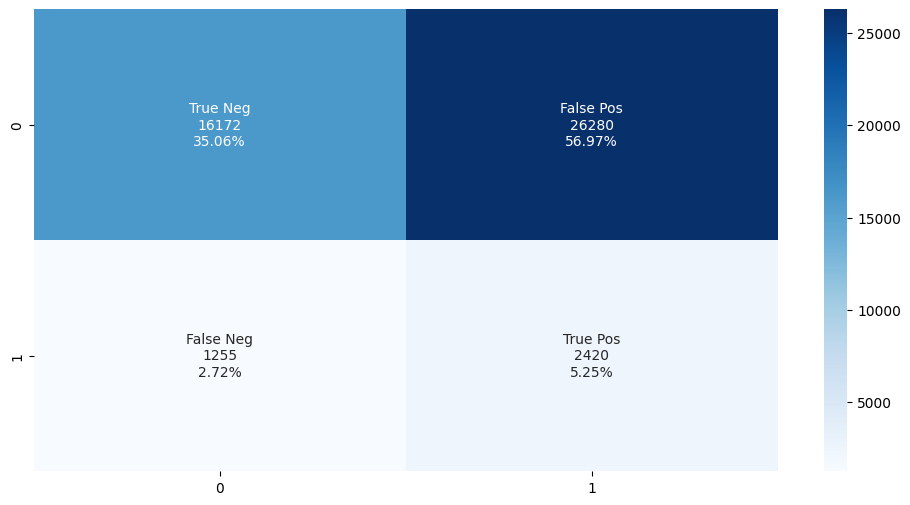

In [46]:
metrics = calcul_metrics(GS.best_estimator_, valid_x, valid_y)
print(classification_report(valid_y, GS.best_estimator_.predict(valid_x)))

logToMLflow(GS.best_estimator_, train_x, val_data, metrics, name="LogReg_Smote_GridSearch", params=GS.best_params_, training_tag="Basic LR model with SMOTE")
displayConfMatrix(GS.best_estimator_, valid_x, valid_y)

# RandomForest

## Baseline, paramètres par défaut

### Sans SMOTE

Précision : 0.92
AUC : 0.72
Score métier : 0.7950007587746872
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     42452
         1.0       0.89      0.00      0.00      3675

    accuracy                           0.92     46127
   macro avg       0.90      0.50      0.48     46127
weighted avg       0.92      0.92      0.88     46127



2024/02/05 15:18:49 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2024/02/05 15:18:52 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1.0, negative label is 0.0.
2024/02/05 15:19:00 INFO mlflow.models.evaluation.default_evaluator: Shap explainer Tree is used.
100%|===================| 3993/4000 [10:09<00:01]        2024/02/05 15:29:10 WARNING mlflow.models.evaluation.default_evaluator: Shap evaluation failed. Reason: ExplainerError('Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was 0.770000, while the model output was 0.760000. If this difference is acceptable you can set check_additivity=False to disable this check.'). Set logging leve

<Figure size 1050x700 with 0 Axes>

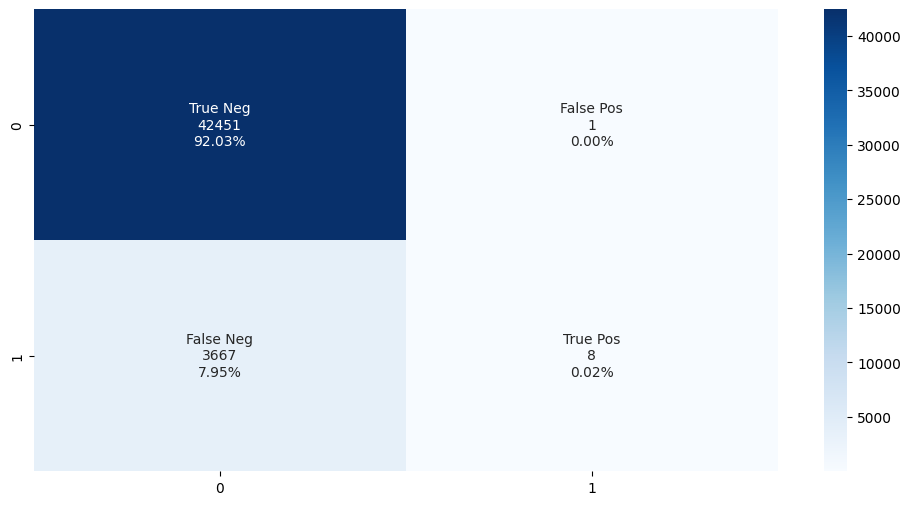

CPU times: total: 14min 55s
Wall time: 18min 48s


In [48]:
%%time

RFC_base = RandomForestClassifier(random_state=0)
RFC_base.fit(train_x, train_y)

metrics = calcul_metrics(RFC_base, valid_x, valid_y)
print(classification_report(valid_y, RFC_base.predict(valid_x)))

val_data = pd.concat([valid_x.reset_index(drop=True), valid_y.reset_index(drop=True)], axis=1)
logToMLflow(RFC_base, train_x, val_data, metrics, name="RndForest_noSmote_noParam", training_tag="RandomForest model no SMOTE no param")
displayConfMatrix(RFC_base, valid_x, valid_y)

### Avec SMOTE

Précision : 0.58
AUC : 0.61
Score métier : 0.7378758644611616
              precision    recall  f1-score   support

         0.0       0.94      0.58      0.72     42452
         1.0       0.10      0.56      0.17      3675

    accuracy                           0.58     46127
   macro avg       0.52      0.57      0.45     46127
weighted avg       0.87      0.58      0.68     46127



2024/02/05 15:45:05 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2024/02/05 15:45:07 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1.0, negative label is 0.0.
2024/02/05 15:45:14 INFO mlflow.models.evaluation.default_evaluator: Shap explainer Permutation is used.
2024/02/05 15:45:14 WARNING mlflow.models.evaluation.default_evaluator: Shap evaluation failed. Reason: ValueError('max_evals=500 is too low for the Permutation explainer, it must be at least 2 * num_features + 1 = 1387!'). Set logging level to DEBUG to see the full traceback.


<Figure size 1050x700 with 0 Axes>

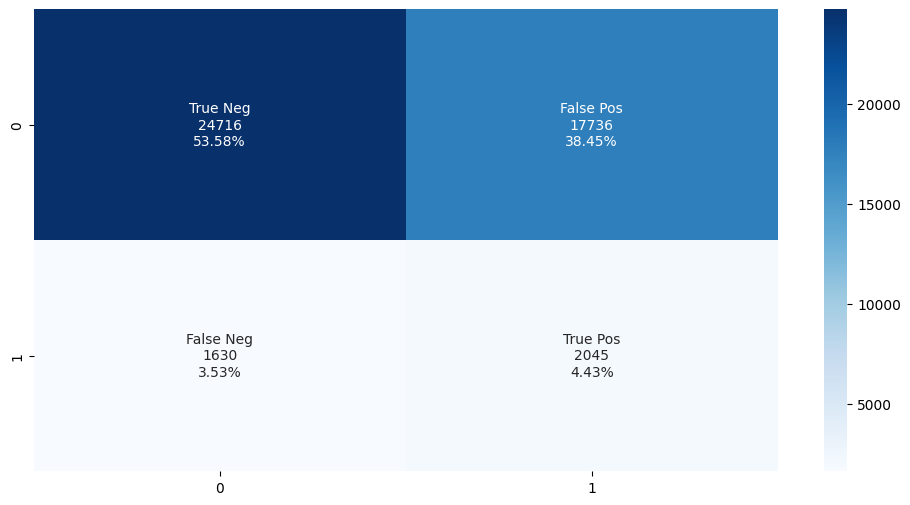

CPU times: total: 12min 9s
Wall time: 15min 6s


In [49]:
%%time

steps = [('over', SMOTE(random_state=0)), ('model', RandomForestClassifier(random_state=0))]
pipeline = Pipeline(steps=steps)
pipeline.fit(train_x, train_y)

metrics = calcul_metrics(pipeline, valid_x, valid_y)
print(classification_report(valid_y, pipeline.predict(valid_x)))

val_data = pd.concat([valid_x.reset_index(drop=True), valid_y.reset_index(drop=True)], axis=1)
logToMLflow(pipeline, train_x, val_data, metrics, name="RndForest_WithSmote_noParam", training_tag="RandomForest model with SMOTE no param")
displayConfMatrix(pipeline, valid_x, valid_y)

## Recherche des meilleurs hyperparamètres

In [54]:
rftest = RandomForestClassifier()
print('Liste des paramètres de RandomForestClassifier :\n')
print(rftest.get_params())

Liste des paramètres de RandomForestClassifier :

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


Utilisation de RandomizedSearchCV sur un nombre important de paramètres pour avoir une idée globale.

In [63]:
%%time

params = {
    'model__bootstrap': [True, False],
    'model__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'model__max_features': ['auto', 'sqrt'],
    'model__min_samples_leaf': [1, 2, 4],
    'model__min_samples_split': [2, 5, 10],
    'model__n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}
    
steps = [('over', SMOTE(random_state=0)), ('model', RandomForestClassifier(random_state=0))]
pipeline = Pipeline(steps=steps)

rf_random = RandomizedSearchCV(pipeline, params, n_iter = 100, scoring=scoring, refit="CustomScorer", cv = 3, random_state=0, n_jobs = -1)#"""estimator = """   """param_distributions = """
# Fit the random search model
rf_random.fit(train_x_10k, train_y_10k)

print("Best parameters :",rf_random.best_params_)
print("Score :",rf_random.best_score_)
resultizeGrid(rf_random)

tuned hyperparameters :(best parameters)  {'model__n_estimators': 600, 'model__min_samples_split': 10, 'model__min_samples_leaf': 2, 'model__max_features': 'sqrt', 'model__max_depth': 10, 'model__bootstrap': True}
accuracy : -0.8165992064113429
CPU times: total: 1min 2s
Wall time: 1h 1min 53s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__n_estimators,param_model__min_samples_leaf,param_model__max_features,param_model__max_depth,param_model__bootstrap,params,mean_test_AUC,std_test_AUC,rank_test_AUC,mean_test_CustomScorer,std_test_CustomScorer,rank_test_CustomScorer
49,95.684098,1.277924,0.706464,0.033683,600,2,sqrt,10,True,"{'model__n_estimators': 600, 'model__min_sampl...",0.711850,0.021174,17,-0.816599,0.009541,1
16,285.733666,1.999877,2.024920,0.399457,1200,1,sqrt,30,True,"{'model__n_estimators': 1200, 'model__min_samp...",0.710564,0.022846,27,-0.820100,0.002850,2
64,370.663151,3.110898,2.462478,0.019478,1600,1,sqrt,None,True,"{'model__n_estimators': 1600, 'model__min_samp...",0.710262,0.021824,29,-0.820100,0.002850,2
27,373.160966,1.392382,2.473115,0.164365,1600,1,sqrt,80,True,"{'model__n_estimators': 1600, 'model__min_samp...",0.710262,0.021824,29,-0.820100,0.002850,2
39,58.306726,1.330677,0.343327,0.059657,200,4,sqrt,80,False,"{'model__n_estimators': 200, 'model__min_sampl...",0.704633,0.022198,49,-0.820100,0.002850,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0.373358,0.026176,0.000000,0.000000,2000,2,auto,40,False,"{'model__n_estimators': 2000, 'model__min_samp...",NaN,NaN,53,NaN,NaN,53
36,0.396557,0.028497,0.000000,0.000000,1000,1,auto,10,False,"{'model__n_estimators': 1000, 'model__min_samp...",NaN,NaN,53,NaN,NaN,53
69,0.430621,0.037382,0.000000,0.000000,2000,1,auto,30,False,"{'model__n_estimators': 2000, 'model__min_samp...",NaN,NaN,53,NaN,NaN,53
56,0.369793,0.018900,0.000000,0.000000,800,4,auto,10,False,"{'model__n_estimators': 800, 'model__min_sampl...",NaN,NaN,53,NaN,NaN,53


Réduction des paramètres en fonction du résultat précédent. GridSearchCV pour trouver les paramètres finaux optimaux.

In [64]:
%%time

params = {
    'model__bootstrap': [True],
    'model__max_depth': [20, 40, 80],
    'model__max_features': ['sqrt'],
    'model__n_estimators': [600, 1000, 1400]
}

steps = [('over', SMOTE(random_state=0)), ('model', RandomForestClassifier(random_state=0))]
pipeline = Pipeline(steps=steps)
GS_RF = GridSearchCV(pipeline, params, scoring=scoring, refit="CustomScorer", n_jobs = -1)

GS_RF.fit(train_x_10k, train_y_10k)

print("tuned hyperparameters :(best parameters) ",GS_RF.best_params_)
print("accuracy :",GS_RF.best_score_)
resultizeGrid(GS_RF)

tuned hyperparameters :(best parameters)  {'model__bootstrap': True, 'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__n_estimators': 600}
accuracy : -0.8211
CPU times: total: 1min 31s
Wall time: 20min 54s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__bootstrap,param_model__max_depth,param_model__max_features,param_model__n_estimators,params,mean_test_AUC,std_test_AUC,rank_test_AUC,mean_test_CustomScorer,std_test_CustomScorer,rank_test_CustomScorer
0,157.486460,2.237420,0.559710,0.038860,True,20,sqrt,600,"{'model__bootstrap': True, 'model__max_depth':...",0.711553,0.026615,1,-0.8211,0.00196,1
1,260.166378,3.756759,0.903423,0.037742,True,20,sqrt,1000,"{'model__bootstrap': True, 'model__max_depth':...",0.710560,0.025711,3,-0.8211,0.00196,1
2,364.204572,4.323227,1.628740,0.263431,True,20,sqrt,1400,"{'model__bootstrap': True, 'model__max_depth':...",0.710802,0.026343,2,-0.8211,0.00196,1
3,164.042899,3.287159,0.598862,0.064597,True,40,sqrt,600,"{'model__bootstrap': True, 'model__max_depth':...",0.708721,0.026182,9,-0.8211,0.00196,1
4,279.192578,5.982766,1.073616,0.148387,True,40,sqrt,1000,"{'model__bootstrap': True, 'model__max_depth':...",0.709733,0.026927,5,-0.8211,0.00196,1
5,401.358474,2.250104,1.567717,0.120787,True,40,sqrt,1400,"{'model__bootstrap': True, 'model__max_depth':...",0.709206,0.027170,8,-0.8211,0.00196,1
6,173.289298,3.650579,0.652715,0.061041,True,80,sqrt,600,"{'model__bootstrap': True, 'model__max_depth':...",0.709285,0.026475,7,-0.8211,0.00196,1
7,275.712583,4.736856,0.931268,0.026983,True,80,sqrt,1000,"{'model__bootstrap': True, 'model__max_depth':...",0.709965,0.027247,4,-0.8211,0.00196,1
8,325.323332,12.979684,1.152659,0.117965,True,80,sqrt,1400,"{'model__bootstrap': True, 'model__max_depth':...",0.709546,0.027330,6,-0.8211,0.00196,1


Application des meilleurs paramètres :

Précision : 0.40
AUC : 0.54
Score métier : 0.8418063173412534
              precision    recall  f1-score   support

         0.0       0.93      0.38      0.54     42452
         1.0       0.08      0.66      0.15      3675

    accuracy                           0.40     46127
   macro avg       0.51      0.52      0.34     46127
weighted avg       0.86      0.40      0.51     46127



2024/02/05 18:40:33 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2024/02/05 18:40:33 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1.0, negative label is 0.0.
2024/02/05 18:40:38 INFO mlflow.models.evaluation.default_evaluator: Shap explainer Permutation is used.
2024/02/05 18:40:38 WARNING mlflow.models.evaluation.default_evaluator: Shap evaluation failed. Reason: ValueError('max_evals=500 is too low for the Permutation explainer, it must be at least 2 * num_features + 1 = 1387!'). Set logging level to DEBUG to see the full traceback.


<Figure size 1050x700 with 0 Axes>

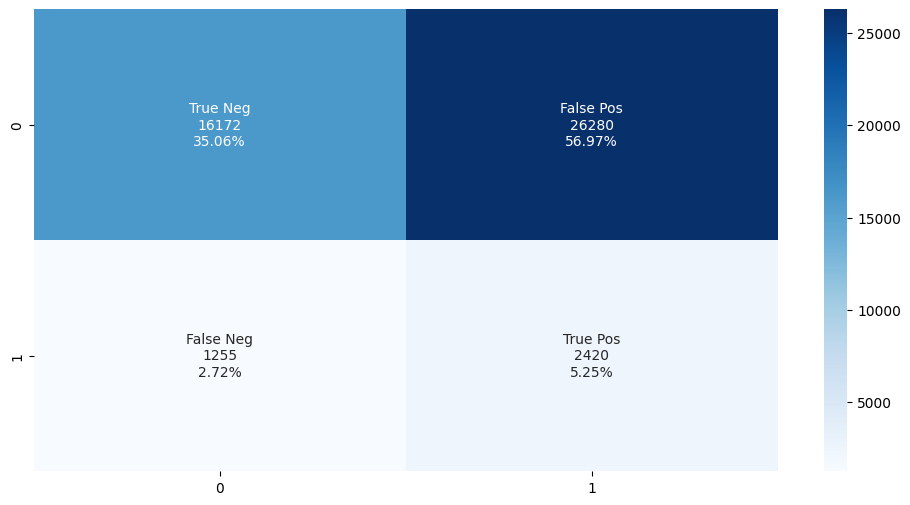

In [65]:
metrics = calcul_metrics(GS.best_estimator_, valid_x, valid_y)
print(classification_report(valid_y, GS.best_estimator_.predict(valid_x)))

logToMLflow(GS.best_estimator_, train_x, val_data, metrics, name="RndForest_Smote_GridSearch", params=GS.best_params_, training_tag="RandomForest model with SMOTE")
displayConfMatrix(GS.best_estimator_, valid_x, valid_y)

# LIGHTGBM

In [ ]:
feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

train_x, valid_x, train_y, valid_y = train_test_split(train_df[feats], train_df['TARGET'], test_size=0.15, random_state=0)

In [ ]:
train_x_30k = train_x[:30000]
train_y_30k = train_y[:30000]

train_x_10k = train_x[:10000]
train_y_10k = train_y[:10000]

## Pramètres par défaut

### Sans SMOTE

In [ ]:
%%time

LGBM_base = LGBMClassifier(random_state=0)
LGBM_base.fit(train_x, train_y)

metrics = calcul_metrics(LGBM_base, valid_x, valid_y)
print(classification_report(valid_y, LGBM_base.predict(valid_x)))

val_data = pd.concat([valid_x.reset_index(drop=True), valid_y.reset_index(drop=True)], axis=1)
logToMLflow(LGBM_base, train_x, val_data, metrics, name="LGBM_noSmote_noParam", training_tag="LGBM model no SMOTE no param")
displayConfMatrix(LGBM_base, valid_x, valid_y)

### Avec SMOTE

In [ ]:
%%time

steps = [('over', SMOTE(random_state=0)), ('model', LGBMClassifier(random_state=0))]
pipeline = Pipeline(steps=steps)
pipeline.fit(train_x, train_y)

metrics = calcul_metrics(pipeline, valid_x, valid_y)
print(classification_report(valid_y, pipeline.predict(valid_x)))

val_data = pd.concat([valid_x.reset_index(drop=True), valid_y.reset_index(drop=True)], axis=1)
logToMLflow(pipeline, train_x, val_data, metrics, name="RndForest_WithSmote_noParam", training_tag="RandomForest model with SMOTE no param")
displayConfMatrix(pipeline, valid_x, valid_y)